<a href="https://colab.research.google.com/github/akashapare/bosch-classification/blob/main/mobile_netV2_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports and declerations

In [18]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageFilter,ImageStat,ImageTransform, ImageOps,ImageShow
import random
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,Adagrad,RMSprop
from tensorflow.keras.applications import MobileNetV2
#start = dt.datetime.now()

In [3]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()


In [4]:
INPUT_DIR = '/content/dataset'
#INPUT_DIR = '/content/drive/MyDrive/edge dataset'
#INPUT_DIR = '/content/drive/MyDrive/gray dataset'
#INPUT_DIR = '/content/drive/MyDrive/gray_eq dataset'

In [5]:
BASE_SIZE =224 
NCATS = 5
tf.random.set_seed(1996)

In [6]:
EPOCHS = 15
size = 224
batchsize = 50

#model for colour images

NOTE:
this model is trained on top of previous weight improvement with 0.86 accuracy


In [19]:

base_model=MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False) 
print(base_model.summary())
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
preds=Dense(NCATS,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)
model.compile(optimizer=Adagrad(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.AUC()])
print(model.summary())


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',validation_split=0.3,)
validation_generator=datagen.flow_from_directory(INPUT_DIR,
                            target_size=(size,size),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batchsize,
                            seed=1996,
                            subset='validation')
train_generator=datagen.flow_from_directory(INPUT_DIR,
                            target_size=(size,size),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batchsize,
                            seed=1996,
                            subset='training')

Found 1026 images belonging to 5 classes.
Found 2403 images belonging to 5 classes.


In [21]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights= dict(enumerate(class_weights))
checkpoint_filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_weights_only=True)
history=model.fit_generator(train_generator,
    steps_per_epoch = train_generator.samples // batchsize,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batchsize,
    epochs = EPOCHS,
    class_weight=class_weights,callbacks=[model_checkpoint_callback],workers=4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/15
48/48 [==============================] - 110s 1s/step - loss: 1.3427 - accuracy: 0.4190 - precision: 0.9231 - recall: 0.0255 - auc: 0.7540 - val_loss: 1.4269 - val_accuracy: 0.3110 - val_precision: 0.9167 - val_recall: 0.0110 - val_auc: 0.7256

Epoch 00001: val_auc improved from -inf to 0.72562, saving model to weights-improvement-01-0.31.hdf5
Epoch 2/15
48/48 [==============================] - 80s 2s/step - loss: 0.9236 - accuracy: 0.6562 - precision: 0.9364 - recall: 0.1377 - auc: 0.8994 - val_loss: 1.2703 - val_accuracy: 0.3960 - val_precision: 0.3712 - val_recall: 0.0490 - val_auc: 0.7943

Epoch 00002: val_auc improved from 0.72562 to 0.79425, saving model to weights-improvement-02-0.40.hdf5
Epoch 3/15
48/48 [==============================] - 78s 2s/step - loss: 0.5834 - accuracy: 0.8564 - precision: 0.9440 - recall: 0.3872 - auc: 0.97

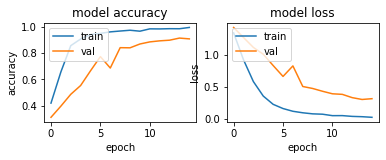

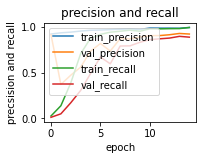

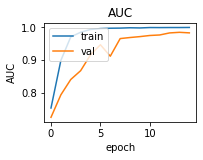

In [22]:
plt.subplot(221)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
  
# summarize history for loss  
  
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  
# precision and recall
plt.subplot(223)  
plt.plot(history.history['precision'],'-')  
plt.plot(history.history['val_precision'],'-') 
plt.plot(history.history['recall'],'-')  
plt.plot(history.history['val_recall'],'-')  
plt.title('precision and recall')  
plt.ylabel('precsision and recall')  
plt.xlabel('epoch')  
plt.legend(['train_precision', 'val_precision','train_recall','val_recall'], loc='upper left')  
plt.show()  

#AUC
  
plt.subplot(224)  
plt.plot(history.history['auc'])  
plt.plot(history.history['val_auc'])  
plt.title('AUC')  
plt.ylabel('AUC')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  

In [23]:
print(history.history.keys())
print(history.history.values())
np.save('history_mobilenetV2_adagrad_lr_0.001.npy',history.history)

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])
dict_values([[1.3427298069000244, 0.9235683083534241, 0.5833557844161987, 0.35764002799987793, 0.22869610786437988, 0.16296075284481049, 0.12033305317163467, 0.09685209393501282, 0.08033334463834763, 0.07469241321086884, 0.05215264484286308, 0.05281440541148186, 0.040789101272821426, 0.035919830203056335, 0.02640572376549244], [0.4190395176410675, 0.6561836004257202, 0.8563535809516907, 0.9069273471832275, 0.9405015110969543, 0.9498512744903564, 0.9613259434700012, 0.9677007794380188, 0.9736506342887878, 0.9664258360862732, 0.9842754006385803, 0.9837499856948853, 0.9855503439903259, 0.9851253628730774, 0.994900107383728], [0.9230769276618958, 0.9364162087440491, 0.9440414309501648, 0.9557979106903076, 0.9644527435302734, 0.9673815965652466, 0.9715536236763, 0.9760869741439819, 0.9788883924484253, 0.9739696383476257, 0.9884318709373474, 0.9878202676773071, 